# Stimulating mossy fibres with naturalistic patterns

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import csv
from numpy.random import randn,rand
from random import expovariate
from stfio.stfio_plot import plot_scalebars
from scipy.signal import butter,filtfilt
from neo.io import NeoHdf5IO

## Process for generating naturalistic stimulation patterns

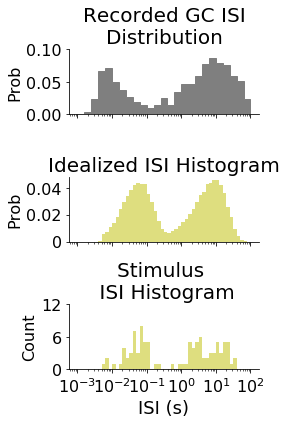

In [5]:
'''Load Granule Cell ISI data'''

f = np.loadtxt('./fig2_data/mistryb1_gc_isi.csv')/100 # contains 'relative frequencies'
f = np.repeat(f,2) # Repeat to obtain heights at bar edges
f = np.append(f,0) # Insert 0 at end so edge finishes at 0
x = np.repeat(10**np.linspace(-3,2,26),2)[1:] # bar edge locations

'''Load Pulse Times'''
pulses = []
with open('/home/luke/Documents/Data/pulses1.csv','rb') as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    for row in reader:
        pulses.append(row)

'''Pulse times are in units of instruction steps. Convert to seconds'''
pulses = np.array([int(pulse) for pulse in pulses[0]])
pulses+=5
pulses = pulses[:-1]
pulses = np.cumsum(pulses)
pulses = np.append(0,pulses)
pulses+=5
pulses = pulses[::2]
pulses = pulses[:-1]

ivls = np.diff(pulses)*10**-4
# Stimulation protocol
ivls_list = [ivls.tolist()]
ivls_irr = ivls_list

'''Sample from Doubly Stochastic Cox Process to generate naturalistic stimuli'''

r_lo = 3; mu_lo = 0.006; sig_lo = 0.12; r_hi = 0.25; mu_hi = 0.0025; sig_hi = 0.01; mixp = 0.55
ISI = []
n = 0

while (len(ISI) < 50000):
    x_lo = r_lo*expovariate(1./r_lo) # sample from exponential distribution
    rej_lo = randn()*sig_lo + mu_lo # rejection probability from normal distribution 
    
    x_hi = r_hi*expovariate(1./r_hi) # sample from second exponential distribution
    rej_hi = randn()*sig_hi + mu_hi # second rejection probability
    
    p = rand() # responsibility
    
    if (x_lo > rej_lo)&(x_hi > max(rej_hi,5e-3)):
        ISI.append(x_lo*(p<mixp) + x_hi*(p>=mixp))
        
    n+=1

ISI = np.array(ISI)

'''Location of bin edges for sample histograms'''
dt = 10**np.linspace(-3,2,51)
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(4,6))


'''Plot Granule Cell ISI'''
ax1.fill(x,f,color='C7')
plt.sca(ax1)
plt.ylim(0,0.1)
plt.yticks(fontsize=16)
plt.title('Recorded GC ISI\nDistribution',fontsize=20)
plt.ylabel('Prob',fontsize=16)

'''Plot Modelled ISI Distribution'''
ax2.hist(ISI,dt,histtype='stepfilled',alpha=0.5,color='y')
ax2.set_title('Idealized ISI Histogram',fontsize=20)
plt.sca(ax2)
plt.yticks((0,1000,2000),(0,1000./50000.,2000./50000.),fontsize=16)
plt.ylabel('Prob',fontsize=16)

'''Plot sample ISI distribution for experiments'''
ax3.hist(ivls,dt,histtype='bar',alpha=0.5,color='y')
ax3.set_xscale('log')
ax3.set_xlabel('ISI (s)',fontsize=18)
ax3.set_title('Stimulus \n ISI Histogram',fontsize=20)
plt.sca(ax3)
plt.xticks(fontsize=16)
plt.yticks([0,6,12],fontsize=16)
plt.ylabel('Count',fontsize=16)

'''Remove ticks from upper and right edges of figure'''
for ax in (ax1,ax2,ax3):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

#fig.suptitle('Generating naturalistic stimuli',x=0.55,y=1.05,fontsize=24)
    
fig.tight_layout()

fig.savefig('./reworked_figs/gc_isi_hists.svg')

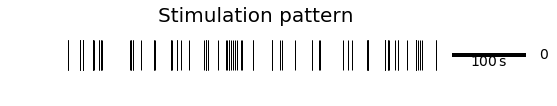

In [8]:
'''Plot stimulation pattern used in experiments as a spiket train'''

fig = plt.figure(figsize=(9,1))

plt.plot(np.cumsum(ivls),np.zeros_like(ivls),'k|',ms=30,lw=3)
ax=plt.gca()
plot_scalebars(ax,xunits='s',sb_xoff=0.2,div=5)
ax.axis('off');
plt.title('Stimulation pattern',fontsize=20,x=0.42)

[txt.set_fontsize(14) for txt in fig.axes[0].texts];

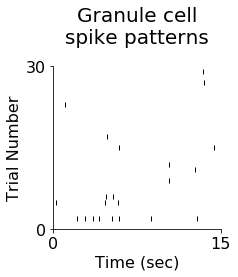

In [4]:
'''Plot spike patterns recorded in vivo as raster, reproduced from Mistry et al (2011)'''

data = np.loadtxt('./fig2_data/mistry_bc_gc_spt.csv',delimiter=',')

fig = plt.figure(figsize=(3,3))
T=data[:,0]
I=data[:,1]
plt.plot(T,I,'|',ms=5,color='k')
plt.ylim(0,30)
plt.xlim(0,15)
plt.xticks([0,15],fontsize=16)
plt.yticks([0,30],fontsize=16)
plt.xlabel('Time (sec)',fontsize=16)
plt.ylabel('Trial Number',fontsize=16)
plt.title('Granule cell\nspike patterns',fontsize=20,y=1.1)


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## Example data stimulated with naturalistic patterns

#### Plotting and data processing functions 

In [35]:
def filter_psc(psc,samp_freq,kwidth=0.0003):
    '''Filter PSCs with narrow gaussian filter'''
    k = gauss_kernel(kwidth,samp_freq,8*kwidth) # filter window is 8 standard deviations
    fpsc =filtfilt(k,[1],psc)
    return fpsc


def gauss_kernel(sigma,sample_rate,duration):
    '''Gaussian kernel shape'''
    l = duration*sample_rate
    x = np.arange(-np.floor(l/2),np.floor(l/2))/sample_rate
    y = (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x**2/(2*sigma**2))) # normal distribution
    y/=sum(y) # area sums to 1
    return y

def butter_highpass(highcut,fs, order=2):
    '''Create butterworth filter'''
    nyq = 0.5*fs
    high = highcut/nyq
    b,a = butter(order, high, btype='highpass')
    return b,a
    
def butter_highpass_filter(data,highcut,fs,order=2):
    '''Filter data using butterworth filter to remove DC and other slow fluctuations'''
    b,a = butter_highpass(highcut,fs,order=order)
    fdata = filtfilt(b,a,data)
    return fdata

def extract_irr_amps(data,pulses,sig_dict,highcut=0.1,order=3):
    '''Extract amplitudes from data given known pulse times'''
    
    # Extraction parameters
    samp_freq = sig_dict['samp_freq']
    tbase = int(sig_dict['tbase']*samp_freq)
    latency = int(sig_dict['latency']*samp_freq)
    win = int(sig_dict['win']*samp_freq)
    argm = sig_dict['argm']
    vdf = sig_dict['vdf']
    
    # High pass filter the data (order 3 butterworth cutoff 0.01 Hz)
    fdata = np.array([])
    for x in data.T:
        x = np.array(x)
        fx = butter_highpass_filter(x,highcut,samp_freq,order=order)
        fdata = np.append(fdata,fx)

    fdata = np.reshape(fdata,np.shape(data.T))
    
    # Clip data to remove prominence of stim artefacts
    if vdf<0:
        fdata = np.clip(fdata,-np.inf,100)
    elif vdf>0:
        fdata = np.clip(fdata,-100,np.inf)
    
    # PSC stats
    peaks = []
    bases = []
    tpeaks = []
    for p in pulses:
        for trace in fdata:
            psc = trace[p+tbase:p+tbase+latency+win] # Extract PSC from trace
            bases.append(np.mean(psc[tbase-10:tbase])) # Estimate baseline 1ms before PSC onset
            mx = argm(psc[latency-win:latency+win]) # Estimate peak
            peaks.append(mx)
            tpeak = np.where(psc==mx)[0][0] # get time of peak within psc
            tpeak+=p+tbase # add time elapsed within whole trace
            tpeaks.append(tpeak)

    peaks = np.array(np.reshape(peaks,[100,len(fdata)]).T)
    tpeaks = np.array(np.reshape(tpeaks,[100,len(fdata)]).T)
    bases = np.array(np.reshape(bases,[100,len(fdata)]).T)
    amps = np.clip((peaks - bases)/vdf,0,np.inf);
    psc_stats = fdata,peaks,tpeaks
    
    return psc_stats


# Load Spike2 Data
def load_irr_data(path,segnum):
    '''Load data from .h5 file'''
    r = NeoHdf5IO(path)
    blk = r.read_block()
    r.close()
    seg = blk.segments
    data = seg[segnum].analogsignalarrays[0]
    return data

def plot_irr_example(psc_stats,colors,figsize=(10,6)):
    '''Plot irregular stimulation data'''
    
    trace1,trace2 = psc_stats[0]
    resps1,resps2 = psc_stats[1]
    tresps1,tresps2 = psc_stats[2]

    dt = 1e-4
    time = np.arange(0,len(trace1)*dt,dt)
    
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=figsize,nrows=2,ncols=2,sharex='row',sharey='row')
    
    '''Plot whole control trace'''
    ax1.plot(time,trace1,color=colors[0])
    ax1.plot(time[tresps1],resps1,'o',markerfacecolor='ivory',markeredgecolor='darkslategray',linewidth=3,markersize=7)
    ax1.axis('off')
    ax1.set_xlim(0,575)
    
    '''Plot whole cch trace'''
    ax2.plot(time,trace2,color=colors[1])
    ax2.plot(time[tresps2],resps2,'o',markerfacecolor='ivory',markeredgecolor='darkslategray',linewidth=3,markersize=7)
    ax2.axis('off')
    plot_scalebars(ax2,xunits='s',yunits='pA',sb_xoff=-0.1,sb_yoff=-0.35)

    '''Extract burst from traces'''
    t_start = int(496.2*10000)
    t_fin = int(496.6*10000)
    trace1=trace1[t_start:t_fin]
    trace2=trace2[t_start:t_fin]

    dt = 1e-1
    time = np.arange(0,len(trace1)*dt,dt)
    
    '''Plot control burst'''
    ax3.plot(time,trace1,color=colors[0],lw=3)
    ax3.axis('off')
    
    '''Plot CCh burst'''
    ax4.plot(time,trace2,color=colors[1],lw=3)
    ax4.axis('off')
    plot_scalebars(ax4,xunits='ms',yunits='pA',sb_xoff=-0.1,sb_yoff=-0.1)

    fig.tight_layout()
    
    return fig

#### Plotting and processing parameters

In [46]:
# Dictionary to describe data processing parameters for EPSCs and IPSCs
esig_dict = {'samp_freq':10000,'tbase':0.001,'latency':0.002,'win':0.002,'argm':np.min,'vdf':-80}
isig_dict = {'samp_freq':10000,'tbase':0.005,'latency':0.009,'win':0.003,'argm':np.max,'vdf': 80}

# Colors for excitatory (reds) and inhibitory (blues)
ecolors = ['#F41111',"maroon"]
icolors = ['#454FE8','#75A4F7']

### Plotting EPSC data 

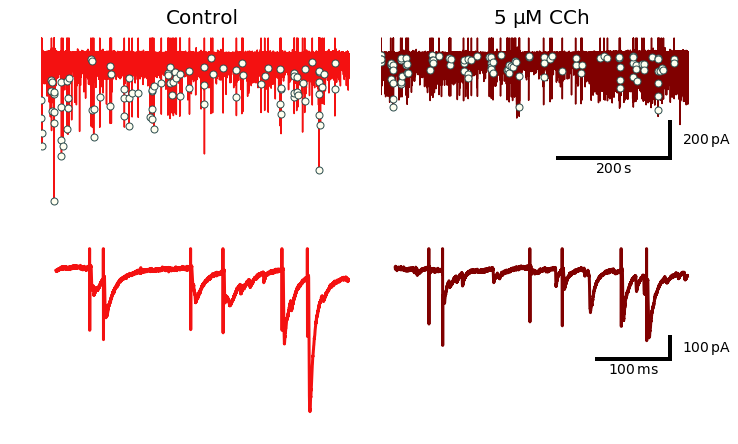

In [47]:
data = load_irr_data('./fig2_data/160902_epsc_cch_1.h5',0)
psc_stats = extract_irr_amps(data,pulses=pulses,sig_dict=esig_dict)
fig = plot_irr_example(psc_stats,colors=ecolors)
fig.axes[0].set_title('Control',fontsize=20)
fig.axes[1].set_title('5 $\mathrm{\mu}$M CCh',fontsize=20)
#fig.suptitle('MF-EPSCs in response to naturalistic stimulation patterns',fontsize=24,y=1.1)
[txt.set_fontsize(14) for txt in fig.axes[1].texts];
[txt.set_fontsize(14) for txt in fig.axes[3].texts];
fig.savefig('./reworked_figs/mf-epsc-cch-natwhole.svg')

### Plotting IPSC data 

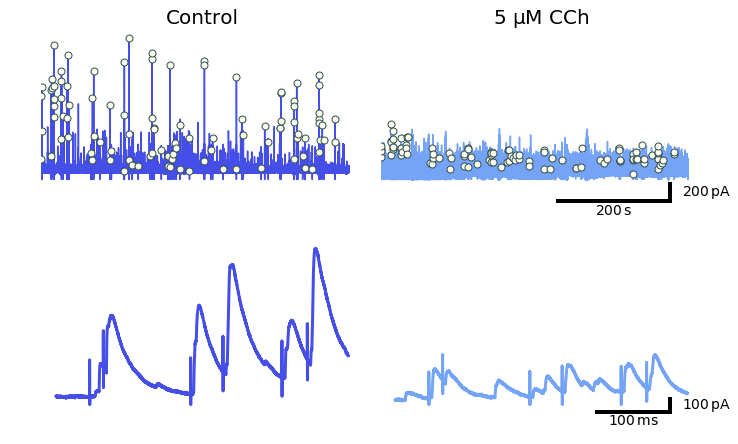

In [51]:
data = load_irr_data('./fig2_data/161026_ipsc_cch_1.h5',0)
psc_stats = extract_irr_amps(data,pulses=pulses,sig_dict=isig_dict)
fig = plot_irr_example(psc_stats,colors=icolors)
fig.axes[0].set_title('Control',fontsize=20)
fig.axes[1].set_title('5 $\mathrm{\mu}$M CCh',fontsize=20)
#fig.suptitle('MF-IPSCs in response to naturalistic stimulation patterns',fontsize=24,y=1.1)

[txt.set_fontsize(14) for txt in fig.axes[1].texts];
[txt.set_fontsize(14) for txt in fig.axes[3].texts];
fig.savefig('./reworked_figs/mf-ipsc-cch-natwhole.svg')